# Ongo Science Consulting Version Notes
This Notebook reads in data from various sources, organizes it, and performs a survival analysis on user retention. Additional features may be added in the future as more granular data is obtained (i.e. user in-app clicks) and more users join the app.


## Data Source Contents


Hierarchy of programs in app: Track -> Session -> Element (some elements are called activities if they are physical activities)  
**UserLog.csv** = dates/times when users opened app <br>
  
  
**ActivityLog.csv** = dates/times when users (referred to as owners here) did different in-app activities (unclear if completed or just clicked on), along with the name of the activity and the time/count (in seconds/counts) of the activity. Also includes the hash codes for the specific acitivity, element, session, and track <br>
**ActivityTemplate.csv** = Unclear. Maybe just names of different activities (i.e. box jumps, up dog). Only has one unique "owner"  
  
**Question.csv** = Owners who asked a question, the "community" they posted to, dates/times, and the title of the question (I think the "title" is likely the full text of the question).      
**QuestionUpvote.csv** = Dates/times that a user upvoted a question. The "question" column corresponds with a specific "id" in the question df.  
**Answer.csv** = The "question" column has a code that corresponds to an "id" in Question.csv. This file has the owner that answered the question and the "text" that they wrote  
**AnswerUpvote.csv** = Dates/times that a user upvoted an answer. The "answer" column corresponds with a specific "id" in the answer df.  
 
**NewsfeedStory.csv** = Dates/times and communities that users posted(?) something. Text can be statements ("lovely morning for a hike!") and questions ("why does the app crash?")  
**NewsfeedStoryComment.csv** = the "owner" that made a comment, the id of the comment, and the id of the "story" that they commented on. Contains no text. Just dates, times, users, and ids. The "story" column is the "id" in NewsfeedStory.csv  
**Comment.csv** = User comments on newsfeed items. The "id" column corresponds with the "comment" column in the NewsfeedStoryComment.csv file. The text of the comment is in comment.csv, but you must look at NewsfeedStoryComment to get the id of the "story" that is being commented on    
  
**TrackSession.csv** = The user, the "track" id (i.e. Marathon Program) and the "trackSession" id (i.e. Day 13: Long Run). Unclear if the user completed it or just clicked on it  
**TrackSessionFeedback.csv** = The user, track and trackSession that was completed(?) and whether the user liked it ("thumbUp" = t) or not ("thumbUp" = f). If the user didn't like it, they can give option feedback. Feedback columns include "thumbsDownTimeReason" and "thumbsDownDifficultyReason" with preset answers, and also "feedbackText" which the user can type in their own comments.  
  

  
**DataActivity.csv** = Data from user Fitbits on the activity (walk/run) and duration (seconds, I think). Fitbit data feature turned off for most users, so most recent data is from Oct 2018. Not worth analyzing for now <br>
**DataSample.csv** = Very Large file, but seems to only correspond to a few unique users. I think the data may be imported from other fitness apps, like the Iphone/apple watch step count or heart rate<br>
**DataWorkoutRun.csv** = The date/time a user started (completed?) a session of a specific track. The track can be something like "Marathon Program," and the session is the corresponding workout, such as "Day 3 -Strength, Agility, and Power"<br>


# Read in Latest Data and Python Libraries

In [60]:
import platform
import pandas as pd
import sklearn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [61]:
# Load in all of the different data files
# Change the "path" variable to the location of the data files
path = '../20190615-010010-' 
UserLog_df = pd.read_csv(path+'UserLog.csv')

ActivityLog_df = pd.read_csv(path+'ActivityLog.csv')
ActivityTemplate_df = pd.read_csv(path+'ActivityTemplate.csv')

DataActivity_df = pd.read_csv(path+'DataActivity.csv')
DataSample_df = pd.read_csv(path+'DataSample.csv')
DataWorkoutRun_df = pd.read_csv(path+'DataWorkoutRun.csv')

Newsfeed_df = pd.read_csv(path+'NewsfeedStory.csv')
NewsfeedComment_df = pd.read_csv(path+'NewsfeedStoryComment.csv')
NewsfeedLike_df = pd.read_csv(path+'NewsfeedStoryLike.csv')
Comment_df = pd.read_csv(path+'Comment.csv')

Question_df = pd.read_csv(path+'Question.csv')
QuestionUpvote_df = pd.read_csv(path+'QuestionUpvote.csv')
Answer_df = pd.read_csv(path+'Answer.csv') #The "question" column corresponds with an "_id" in the question df
AnswerUpvote_df = pd.read_csv(path+'AnswerUpvote.csv')

TrackSession_df = pd.read_csv(path+'TrackSessionComplete.csv')
TrackFeedback_df = pd.read_csv(path+'TrackSessionFeedback.csv')


## Clean Data
### Remove Data prior to Feb 2019
February 2019 was when the latest version of the app was launched, so data prior to this is not relevant

In [62]:
# Filter out data from old app version (prior to february 2019)
# The dates in the files need to first be converted to datetime format before they may be manipulated
UserLog_df.dateValue = pd.to_datetime(UserLog_df.dateValue,infer_datetime_format=True)
ActivityLog_df.date = pd.to_datetime(ActivityLog_df.date,infer_datetime_format=True)
DataWorkoutRun_df.createdAt = pd.to_datetime(DataWorkoutRun_df.createdAt, infer_datetime_format=True)
DataSample_df.updatedAt = pd.to_datetime(DataSample_df.updatedAt,infer_datetime_format=True)

Answer_df.createdAt = pd.to_datetime(Answer_df.createdAt,infer_datetime_format=True)
AnswerUpvote_df.createdAt = pd.to_datetime(AnswerUpvote_df.createdAt,infer_datetime_format=True)

Question_df.updatedAt = pd.to_datetime(Question_df.updatedAt,infer_datetime_format=True)
QuestionUpvote_df.updatedAt = pd.to_datetime(QuestionUpvote_df.updatedAt,infer_datetime_format=True)

TrackSession_df.updatedAt = pd.to_datetime(TrackSession_df.updatedAt,infer_datetime_format=True)
TrackFeedback_df.updatedAt = pd.to_datetime(TrackFeedback_df.updatedAt, infer_datetime_format=True)

Newsfeed_df.createdAt = pd.to_datetime(Newsfeed_df.createdAt, infer_datetime_format=True)
NewsfeedComment_df.createdAt = pd.to_datetime(NewsfeedComment_df.createdAt, infer_datetime_format=True)
NewsfeedLike_df.createdAt = pd.to_datetime(NewsfeedLike_df.createdAt, infer_datetime_format=True)
Comment_df.createdAt = pd.to_datetime(Comment_df.createdAt, infer_datetime_format=True)



In [63]:
# Now that the dates have been converted to datetime, each dataset can be filtered by date

# DataActivity.csv and DataSample.csv has "startDate" and "createdAt" time columns for the collected fitbit data. 
# I believe that the "startDate" column is for when the fitbit was activated, and the "createdAt" 
# is for when the specific activity was done. The startDate can be 2 years prior to "createdAt"


UserLog_df = UserLog_df[(UserLog_df['dateValue'].dt.year == 2019) & (UserLog_df['dateValue'].dt.month >=2)]
ActivityLog_df = ActivityLog_df[(ActivityLog_df['date'].dt.year == 2019) & (ActivityLog_df['date'].dt.month >=2)]
DataWorkoutRun_df = DataWorkoutRun_df[(DataWorkoutRun_df['createdAt'].dt.year == 2019) & (DataWorkoutRun_df['createdAt'].dt.month >=2)]
DataSample_df = DataSample_df[(DataSample_df['updatedAt'].dt.year == 2019) & (DataSample_df['updatedAt'].dt.month >= 2)]

Question_df = Question_df[(Question_df['updatedAt'].dt.year == 2019)& (Question_df['updatedAt'].dt.month>=2)]
QuestionUpvote_df = QuestionUpvote_df[(QuestionUpvote_df['updatedAt'].dt.year == 2019)& (QuestionUpvote_df['updatedAt'].dt.month>=2)]

Answer_df = Answer_df[(Answer_df['createdAt'].dt.year == 2019)& (Answer_df['createdAt'].dt.month>=2)]
AnswerUpvote_df = AnswerUpvote_df[(AnswerUpvote_df['createdAt'].dt.year == 2019)& (AnswerUpvote_df['createdAt'].dt.month>=2)]

TrackSession_df = TrackSession_df[(TrackSession_df['updatedAt'].dt.year == 2019)& (TrackSession_df['updatedAt'].dt.month>=2)]
TrackFeedback_df = TrackFeedback_df[(TrackFeedback_df['updatedAt'].dt.year == 2019)& (TrackFeedback_df['updatedAt'].dt.month>=2)]

Newsfeed_df = Newsfeed_df[(Newsfeed_df['createdAt'].dt.year == 2019)& (Newsfeed_df['createdAt'].dt.month>=2)]
NewsfeedComment_df = NewsfeedComment_df[(NewsfeedComment_df['createdAt'].dt.year == 2019)& (NewsfeedComment_df['createdAt'].dt.month>=2)]
NewsfeedLike_df = NewsfeedLike_df[(NewsfeedLike_df['createdAt'].dt.year == 2019)& (NewsfeedLike_df['createdAt'].dt.month>=2)]
Comment_df = Comment_df[(Comment_df['createdAt'].dt.year == 2019)& (Comment_df['createdAt'].dt.month>=2)]


### Change all user identifiers to "User" rather than "Owner"
This is done to simplify future referenecs to each file

In [64]:
#Rename the column "owner" to "user" to avoid naming mixups
DataWorkoutRun_df=DataWorkoutRun_df.rename(columns = {'owner':'user'})
ActivityLog_df=ActivityLog_df.rename(columns = {'owner':'user'})
DataActivity_df = DataActivity_df.rename(columns = {'owner':'user'})
DataSample_df = DataSample_df.rename(columns = {'owner':'user'})

Question_df = Question_df.rename(columns = {'owner':'user'})
QuestionUpvote_df = QuestionUpvote_df.rename(columns = {'owner':'user'})

Answer_df = Answer_df.rename(columns = {'owner':'user'})

Newsfeed_df = Newsfeed_df.rename(columns = {'owner':'user'})
NewsfeedComment_df = NewsfeedComment_df.rename(columns = {'owner':'user'})
Comment_df = Comment_df.rename(columns = {'owner':'user'})

### Remove App Developer IDs
Known app developer ids should be removed as they skew the data

In [65]:
# Calculate the current "power users" but then put them in a static list
# so that this code can be used in the future
# "Power users" are operationally defined as those that have logged in more than 250 times since Feb 2019

#power_users = UserLog_df.groupby('user')['dateValue'].count().keys()[(
#    UserLog_df.groupby('user')['dateValue'].count() > 250)]

power_users = ['00000000-56ff-538b-2223-e1800b5e3ddb',
       '00000000-5851-ee08-eb34-e20acc5af74e',
       '00000000-5854-86b5-f590-f71e3879047b',
       '35d15dbe-3258-439b-b833-21bdee3cfeae']


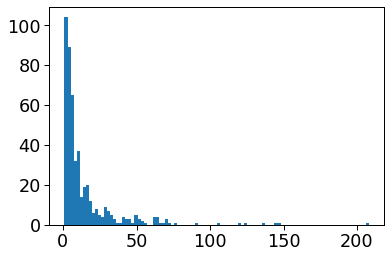

In [66]:
test=UserLog_df[~UserLog_df['user'].isin(power_users)]
len(test.user.unique())
plt.hist(test.groupby('user')['dateValue'].count(), bins=100);

In [67]:
UserLog_df=UserLog_df[~UserLog_df['user'].isin(power_users)]
ActivityLog_df = ActivityLog_df[~ActivityLog_df['user'].isin(power_users)]
DataActivity_df = DataActivity_df[~DataActivity_df['user'].isin(power_users)]
DataSample_df = DataSample_df[~DataSample_df['user'].isin(power_users)]
DataWorkoutRun_df = DataWorkoutRun_df[~DataWorkoutRun_df['user'].isin(power_users)]

Question_df = Question_df[~Question_df['user'].isin(power_users)]
QuestionUpvote_df = QuestionUpvote_df[~QuestionUpvote_df['user'].isin(power_users)]

Answer_df = Answer_df[~Answer_df['user'].isin(power_users)]
AnswerUpvote_df = AnswerUpvote_df[~AnswerUpvote_df['user'].isin(power_users)]

TrackSession_df = TrackSession_df[~TrackSession_df['user'].isin(power_users)]
TrackFeedback_df = TrackFeedback_df[~TrackFeedback_df['user'].isin(power_users)]

Newsfeed_df = Newsfeed_df[~Newsfeed_df['user'].isin(power_users)]
NewsfeedComment_df = NewsfeedComment_df[~NewsfeedComment_df['user'].isin(power_users)]
NewsfeedLike_df =NewsfeedLike_df[~NewsfeedLike_df['user'].isin(power_users)]
Comment_df = Comment_df[~Comment_df['user'].isin(power_users)]

# Calculate User Login Frequencies
Manipulations on the "UserLog" file 
## Time (from today) Since Last Login

In [68]:
#Calculate the time since the user last opened the app (relative to the most recent time in the data dump)
#This will be used to evaluate user churn
UserLog_df = UserLog_df.sort_values(by=['user','dateValue'],ascending=True)
last_login_in_data = UserLog_df.dateValue.max() #have reference date be the most recent login in the data
UserLog_df['LoginTime_FromToday'] = last_login_in_data-UserLog_df.dateValue
UserLog_df.head(50)

,_id,user,type,dateValue,value,content,createdAt,updatedAt,LoginTime_FromToday
11393,1f1a62a8-d40e-4c3b-9281-a2256d35b2c0,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-01 00:16:00.643000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS...",2019-02-01 00:16:00.644+00,2019-02-01 00:16:00.644+00,134 days 00:09:59.960000
11263,87d6e941-e966-4685-b4e7-e73bd1a417df,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-04 18:41:01.585000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-04 18:41:01.586+00,2019-02-04 18:41:01.586+00,130 days 05:44:59.018000
11232,e0ee65b2-946f-425f-9dcc-ee1f10011bee,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-05 19:49:43.793000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-05 19:49:43.793+00,2019-02-05 19:49:43.793+00,129 days 04:36:16.810000
11211,ec10d19d-839b-4e19-b2de-788d8ee5c630,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-05 23:48:39.925000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Windows NT 10.0; Win64;...",2019-02-05 23:48:39.925+00,2019-02-05 23:48:39.925+00,129 days 00:37:20.678000
10991,0d9b69c4-e19c-44e7-b2a4-919f55068478,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-07 20:36:59.449000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-07 20:36:59.449+00,2019-02-07 20:36:59.449+00,127 days 03:49:01.154000
10841,405c3fb0-e79b-4502-893b-591f06d5cc8d,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-08 22:10:55.085000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS...",2019-02-08 22:10:55.086+00,2019-02-08 22:10:55.086+00,126 days 02:15:05.518000
10711,8f7f79ff-870d-48bc-8071-4e2383576255,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-11 18:57:08.740000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-11 18:57:08.74+00,2019-02-11 18:57:08.74+00,123 days 05:28:51.863000
10647,5efa0701-8928-4b81-8c31-afb921dcef0e,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-13 20:57:06.464000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Windows NT 10.0; Win64;...",2019-02-13 20:57:06.465+00,2019-02-13 20:57:06.465+00,121 days 03:28:54.139000
10572,633252a2-0c51-4d95-8a41-a61ce20adb54,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-18 21:17:54.499000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11151....",2019-02-18 21:17:54.499+00,2019-02-18 21:17:54.499+00,116 days 03:08:06.104000
10562,53c5b49a-5209-4a36-878a-6d9f3fef4dcb,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-19 01:17:02.343000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Windows NT 10.0; Win64;...",2019-02-19 01:17:02.344+00,2019-02-19 01:17:02.344+00,115 days 23:08:58.260000


### Classify as Active or Inactive

In [69]:
# Currently active users have used the app within the last 30 days
# Note that this calculation classifies each login as "active" or "inactive." The overall user 
# classification can be given by a groupby statement taking the max of the LoggedInLast30Days_Y_N column
# as inactive users will have all 0's, and active users will have at least one 1. 
UserLog_df['LoggedInLast30Days_Y_N'] = UserLog_df['LoginTime_FromToday'].apply(
    lambda x: 1 if x / pd.Timedelta(days=1) <= 30. else 0)

UserLog_df.head()

,_id,user,type,dateValue,value,content,createdAt,updatedAt,LoginTime_FromToday,LoggedInLast30Days_Y_N
11393,1f1a62a8-d40e-4c3b-9281-a2256d35b2c0,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-01 00:16:00.643000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS...",2019-02-01 00:16:00.644+00,2019-02-01 00:16:00.644+00,134 days 00:09:59.960000,0
11263,87d6e941-e966-4685-b4e7-e73bd1a417df,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-04 18:41:01.585000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-04 18:41:01.586+00,2019-02-04 18:41:01.586+00,130 days 05:44:59.018000,0
11232,e0ee65b2-946f-425f-9dcc-ee1f10011bee,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-05 19:49:43.793000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-05 19:49:43.793+00,2019-02-05 19:49:43.793+00,129 days 04:36:16.810000,0
11211,ec10d19d-839b-4e19-b2de-788d8ee5c630,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-05 23:48:39.925000+00:00,NaN,"{""agent"":""Mozilla/5.0 (Windows NT 10.0; Win64;...",2019-02-05 23:48:39.925+00,2019-02-05 23:48:39.925+00,129 days 00:37:20.678000,0
10991,0d9b69c4-e19c-44e7-b2a4-919f55068478,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-07 20:36:59.449000+00:00,NaN,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-07 20:36:59.449+00,2019-02-07 20:36:59.449+00,127 days 03:49:01.154000,0


## Login Frequency
Note 6-16-19: Plan = Split the date column into the year, month, and day. Can then bin the number of logins by day and add columns for the number of other activites (session, track, newsfeed, comments etc) that the user did that day. This will allow me to plot the app usage per day over time. It may turn out that binning by week (or 2 days, 3 days etc) is better, but I will start with days. 

In [70]:
#Calculate the time between each login for each user.
UserLog_df['TimeBetweenLogins'] = UserLog_df.sort_values(['user','dateValue']).groupby('user')['dateValue'].diff()

#Replace the first login for each user with 0 days
UserLog_df = UserLog_df.fillna(0)

#Convert time between logins to hours and days
UserLog_df['Hours_BetweenLogins'] = UserLog_df['TimeBetweenLogins'].dt.total_seconds()/3600
UserLog_df['Days_BetweenLogins'] = UserLog_df['TimeBetweenLogins'].dt.total_seconds()/86400


In [71]:
# For each user, calculate the total amount of time that they have used the app after each login
# as well as the total number of logins
unique_users = []
list_of_total_times = []
total_num_logins = [1]*len(UserLog_df.user)
for i in range(0, len(UserLog_df.user)):
    user_id = UserLog_df.user.iloc[i]
    
    #Check to see if iterated to a new user
    #If so, add their name to the list and add 0 to the list of total times
    if user_id not in unique_users:
        unique_users.append(user_id)
        
        
        list_of_total_times.append(0)
        logins = 0
      
    #If the user isn't new, add up the total time they have used the app
    else:
        logins += 1
        total_num_logins[i] = total_num_logins[i] + logins
        
        added_time = UserLog_df.Hours_BetweenLogins.iloc[i]+list_of_total_times[i-1]
        list_of_total_times.append(added_time)

UserLog_df['Hours_Since_First_Login'] = list_of_total_times
UserLog_df['Days_Since_First_Login'] = UserLog_df['Hours_Since_First_Login']/24
UserLog_df['Login_Count'] = total_num_logins #can keep track of how many logins the user did

In [72]:
UserLog_df['Year']=UserLog_df.dateValue.dt.year
UserLog_df['Month']=UserLog_df.dateValue.dt.month
UserLog_df['Day']=UserLog_df.dateValue.dt.day
UserLog_df.head()

,_id,user,type,dateValue,value,content,createdAt,updatedAt,LoginTime_FromToday,LoggedInLast30Days_Y_N,TimeBetweenLogins,Hours_BetweenLogins,Days_BetweenLogins,Hours_Since_First_Login,Days_Since_First_Login,Login_Count,Year,Month,Day
11393,1f1a62a8-d40e-4c3b-9281-a2256d35b2c0,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-01 00:16:00.643000+00:00,0.0,"{""agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS...",2019-02-01 00:16:00.644+00,2019-02-01 00:16:00.644+00,134 days 00:09:59.960000,0,0 days 00:00:00,0.000000,0.000000,0.000000,0.000000,1,2019,2,1
11263,87d6e941-e966-4685-b4e7-e73bd1a417df,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-04 18:41:01.585000+00:00,0.0,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-04 18:41:01.586+00,2019-02-04 18:41:01.586+00,130 days 05:44:59.018000,0,3 days 18:25:00.942000,90.416928,3.767372,90.416928,3.767372,2,2019,2,4
11232,e0ee65b2-946f-425f-9dcc-ee1f10011bee,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-05 19:49:43.793000+00:00,0.0,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-05 19:49:43.793+00,2019-02-05 19:49:43.793+00,129 days 04:36:16.810000,0,1 days 01:08:42.208000,25.145058,1.047711,115.561986,4.815083,3,2019,2,5
11211,ec10d19d-839b-4e19-b2de-788d8ee5c630,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-05 23:48:39.925000+00:00,0.0,"{""agent"":""Mozilla/5.0 (Windows NT 10.0; Win64;...",2019-02-05 23:48:39.925+00,2019-02-05 23:48:39.925+00,129 days 00:37:20.678000,0,0 days 03:58:56.132000,3.982259,0.165927,119.544245,4.981010,4,2019,2,5
10991,0d9b69c4-e19c-44e7-b2a4-919f55068478,00000000-5704-6615-a2ab-44376358dc8e,auth.login,2019-02-07 20:36:59.449000+00:00,0.0,"{""agent"":""Mozilla/5.0 (X11; CrOS x86_64 11021....",2019-02-07 20:36:59.449+00,2019-02-07 20:36:59.449+00,127 days 03:49:01.154000,0,1 days 20:48:19.524000,44.805423,1.866893,164.349668,6.847903,5,2019,2,7


# Check In-App Activities

## Calculate Times of Activities Relative to First Login
### Make Dictionary of Users and Start Times

In [73]:
# Get the first login time for each user and save them into a dictionary
user_list = UserLog_df.groupby('user')['dateValue'].min().keys().tolist()
first_login_time = UserLog_df.groupby('user')['dateValue'].min().values

user_start_dictionary = dict(zip(user_list, first_login_time))


In [74]:
#Map the user start time dictionary onto each of the data files so that they have a new column
#containing the date that the user first logged into the app
#This may then be used to calculate the time between in-app activities, relative to the first login time
ActivityLog_df['DateTime_of_First_Login']= ActivityLog_df['user'].map(user_start_dictionary)
DataWorkoutRun_df['DateTime_of_First_Login'] = DataWorkoutRun_df['user'].map(user_start_dictionary)

Newsfeed_df['DateTime_of_First_Login'] = Newsfeed_df['user'].map(user_start_dictionary)
NewsfeedComment_df['DateTime_of_First_Login'] = NewsfeedComment_df['user'].map(user_start_dictionary)
NewsfeedLike_df['DateTime_of_First_Login'] = NewsfeedLike_df['user'].map(user_start_dictionary)
Comment_df['DateTime_of_First_Login'] = Comment_df['user'].map(user_start_dictionary)

Question_df['DateTime_of_First_Login'] = Question_df['user'].map(user_start_dictionary)
QuestionUpvote_df['DateTime_of_First_Login'] =QuestionUpvote_df['user'].map(user_start_dictionary)
Answer_df['DateTime_of_First_Login'] = Answer_df['user'].map(user_start_dictionary)
AnswerUpvote_df['DateTime_of_First_Login'] = AnswerUpvote_df['user'].map(user_start_dictionary)

TrackSession_df['DateTime_of_First_Login'] = TrackSession_df['user'].map(user_start_dictionary)
TrackFeedback_df['DateTime_of_First_Login'] = TrackFeedback_df['user'].map(user_start_dictionary)

### Calculate Relative Time of In-App Activity

In [75]:
#Remove timezone information and calculate the time since the user first opened the app
#for binning into days / weeks
#The timezone info must be removed or the code won't work
ActivityLog_df['Days_From_FirstLogin']= (ActivityLog_df['date'].dt.tz_convert(None) - ActivityLog_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
DataWorkoutRun_df['Days_From_FirstLogin'] = (DataWorkoutRun_df['createdAt'].dt.tz_convert(None) - DataWorkoutRun_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)

Newsfeed_df['Days_From_FirstLogin'] = (Newsfeed_df['createdAt'].dt.tz_convert(None) - Newsfeed_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
NewsfeedComment_df['Days_From_FirstLogin'] = (NewsfeedComment_df['createdAt'].dt.tz_convert(None) - NewsfeedComment_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
NewsfeedLike_df['Days_From_FirstLogin'] = (NewsfeedLike_df['createdAt'].dt.tz_convert(None) - NewsfeedLike_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
Comment_df['Days_From_FirstLogin'] = (Comment_df['createdAt'].dt.tz_convert(None) - Comment_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)

Question_df['Days_From_FirstLogin'] = (Question_df['updatedAt'].dt.tz_convert(None) - Question_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
QuestionUpvote_df['Days_From_FirstLogin'] = (QuestionUpvote_df['updatedAt'].dt.tz_convert(None) - QuestionUpvote_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
Answer_df['Days_From_FirstLogin'] = (Answer_df['createdAt'].dt.tz_convert(None) - Answer_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
AnswerUpvote_df['Days_From_FirstLogin'] = (AnswerUpvote_df['createdAt'].dt.tz_convert(None) - AnswerUpvote_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)

TrackSession_df['Days_From_FirstLogin'] = (TrackSession_df['updatedAt'].dt.tz_convert(None) - TrackSession_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)
TrackFeedback_df['Days_From_FirstLogin'] = (TrackFeedback_df['updatedAt'].dt.tz_convert(None) - TrackFeedback_df['DateTime_of_First_Login'])/pd.Timedelta(days = 1)

In [76]:
#Convert the "Days_From_FirstLogin" to an integer day value
#This rounds down to the nearest whole number, and allows for easier math and comparisons
ActivityLog_df['Days_From_FirstLogin'] = [int(x) for x in ActivityLog_df['Days_From_FirstLogin']]
DataWorkoutRun_df['Days_From_FirstLogin'] = [int(x) for x in DataWorkoutRun_df['Days_From_FirstLogin']]

Newsfeed_df['Days_From_FirstLogin'] = [int(x) for x in Newsfeed_df['Days_From_FirstLogin']]
NewsfeedComment_df['Days_From_FirstLogin'] = [int(x) for x in NewsfeedComment_df['Days_From_FirstLogin']]
NewsfeedLike_df['Days_From_FirstLogin'] = [int(x) for x in NewsfeedLike_df['Days_From_FirstLogin']]
Comment_df['Days_From_FirstLogin'] = [int(x) for x in Comment_df['Days_From_FirstLogin']]

Question_df['Days_From_FirstLogin'] = [int(x) for x in Question_df['Days_From_FirstLogin']]
QuestionUpvote_df['Days_From_FirstLogin'] = [int(x) for x in QuestionUpvote_df['Days_From_FirstLogin']]
Answer_df['Days_From_FirstLogin'] = [int(x) for x in Answer_df['Days_From_FirstLogin']]
AnswerUpvote_df['Days_From_FirstLogin'] = [int(x) for x in AnswerUpvote_df['Days_From_FirstLogin']]

TrackSession_df['Days_From_FirstLogin'] = [int(x) for x in TrackSession_df['Days_From_FirstLogin']]
TrackFeedback_df['Days_From_FirstLogin'] = [int(x) for x in TrackFeedback_df['Days_From_FirstLogin']]

UserLog_df['Days_From_FirstLogin'] = [int(x) for x in UserLog_df['Days_Since_First_Login']]
UserLog_df['LoginTime_FromToday'] = UserLog_df['LoginTime_FromToday']/pd.Timedelta(days = 1)

### Merge Dataframes by user and days_from_firstlogin

In [77]:
#Set up Master dataframe to merge everything to
Master_Day_df = pd.DataFrame(UserLog_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
Master_Day_df = Master_Day_df.rename(columns = {'_id':'Logins'}) #The "Logins" column is the total number of logins on the respective day
Master_Day_df.head()

Logins
user                                 Days_From_FirstLogin        
00000000-5704-6615-a2ab-44376358dc8e 0                          1
                                     3                          1
                                     4                          2
                                     6                          1
                                     7                          1

In [78]:
#keep track of the time from today that the user logged in
time_from_today_df = pd.DataFrame(UserLog_df.groupby(['user','Days_From_FirstLogin'])['LoginTime_FromToday'].min())
Master_Day_df = pd.merge(Master_Day_df, time_from_today_df['LoginTime_FromToday'], left_index=True, right_on=['user','Days_From_FirstLogin'], how='outer')
Master_Day_df = Master_Day_df.rename(columns = {'LoginTime_FromToday':'Days_Ago_Logged_In'})
Master_Day_df.head()

Logins  \
user                                 Days_From_FirstLogin           
00000000-5704-6615-a2ab-44376358dc8e 0                          1   
                                     3                          1   
                                     4                          2   
                                     6                          1   
                                     7                          1   

                                                           Days_Ago_Logged_In  
user                                 Days_From_FirstLogin                      
00000000-5704-6615-a2ab-44376358dc8e 0                             134.006944  
                                     3                             130.239572  
                                     4                             129.025934  
                                     6                             127.159041  
                                     7                             126.093814

In [79]:
#Add boolean for if the login was within the last 30 days
logged_in_last_30days_df = pd.DataFrame(UserLog_df.groupby(['user','Days_From_FirstLogin'])['LoggedInLast30Days_Y_N'].mean())
Master_Day_df = pd.merge(Master_Day_df, logged_in_last_30days_df['LoggedInLast30Days_Y_N'], left_index=True, right_on=['user','Days_From_FirstLogin'], how='outer')


In [80]:
#Add column for the number of activities in ActivityLog_df that the user did
num_activities_df = pd.DataFrame(ActivityLog_df.groupby(['user','Days_From_FirstLogin'])['date'].count())
num_activities_df = num_activities_df.rename(columns = {'date':'num_activities'})
Master_Day_df = pd.merge(Master_Day_df,num_activities_df['num_activities'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')


In [81]:
#Add column for the number of sessions the user did each login
num_session_df = pd.DataFrame(TrackSession_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
num_session_df = num_session_df.rename(columns={'_id':'num_sessions'})
Master_Day_df = pd.merge(Master_Day_df,num_session_df['num_sessions'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')


In [82]:
#Add column for the number of data_workout_run activities the user did
run_workout_df = pd.DataFrame(DataWorkoutRun_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
run_workout_df = run_workout_df.rename(columns={'_id':'num_run_workouts'})
Master_Day_df = pd.merge(Master_Day_df,run_workout_df['num_run_workouts'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [83]:
#Add column for if the user left feedback on a session (different columns for positive and negative)
#TrackFeedback_df.groupby(['user','Days_From_FirstLogin'])['thumbsUp'].count()
TrackFeedback_df['Gave_Thumbs_Up'] = [1 if x=='t' else 0 for x in TrackFeedback_df['thumbsUp']]
TrackFeedback_df['Gave_Thumbs_Down'] = [1 if x=='f' else 0 for x in TrackFeedback_df['thumbsUp']]

Thumb_up_df = pd.DataFrame(TrackFeedback_df.groupby(['user','Days_From_FirstLogin'])['Gave_Thumbs_Up'].sum())
Thumb_down_df = pd.DataFrame(TrackFeedback_df.groupby(['user','Days_From_FirstLogin'])['Gave_Thumbs_Down'].sum())
                           
Master_Day_df = pd.merge(Master_Day_df,Thumb_up_df['Gave_Thumbs_Up'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')
Master_Day_df = pd.merge(Master_Day_df,Thumb_down_df['Gave_Thumbs_Down'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')



In [84]:
#Add column for number of times people posted to their newsfeed
Newsfeed_df.head()
newsfeed_post_df = pd.DataFrame(Newsfeed_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
newsfeed_post_df = newsfeed_post_df.rename(columns = {'_id':'num_newsfeed_posts'})

Master_Day_df = pd.merge(Master_Day_df,newsfeed_post_df['num_newsfeed_posts'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')


In [85]:
#Add columns for newsfeed comments (only ~30-40 people, but maybe they all stayed?)
NewsfeedComment_df.head()
newsfeed_comment_df = pd.DataFrame(NewsfeedComment_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
newsfeed_comment_df = newsfeed_comment_df.rename(columns = {'_id':'num_newsfeed_comments'})

Master_Day_df = pd.merge(Master_Day_df,newsfeed_comment_df['num_newsfeed_comments'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [86]:
#add column for if a user liked something on the newsfeed
NewsfeedLike_df.head()

newsfeed_like_df = pd.DataFrame(NewsfeedLike_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
newsfeed_like_df = newsfeed_like_df.rename(columns = {'_id':'num_newsfeed_likes'})

Master_Day_df = pd.merge(Master_Day_df,newsfeed_like_df['num_newsfeed_likes'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [87]:
#add column for if a user asked a question
Question_df.head()

asked_q_df = pd.DataFrame(Question_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
asked_q_df = asked_q_df.rename(columns = {'_id':'num_questions_asked'})

Master_Day_df = pd.merge(Master_Day_df,asked_q_df['num_questions_asked'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [88]:
#Add column for if the user upvoted a question
QuestionUpvote_df.head()

q_upvote_df = pd.DataFrame(QuestionUpvote_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
q_upvote_df = q_upvote_df.rename(columns = {'_id':'num_questions_upvoted'})

Master_Day_df = pd.merge(Master_Day_df,q_upvote_df['num_questions_upvoted'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [89]:
#Add column for if a user posted an answer
Answer_df.head()

q_answer_df = pd.DataFrame(Answer_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
q_answer_df = q_answer_df.rename(columns = {'_id':'num_answers_posted'})

Master_Day_df = pd.merge(Master_Day_df,q_answer_df['num_answers_posted'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [90]:
#add column for if a user upvoted an answer
AnswerUpvote_df.head()

answer_upvote_df = pd.DataFrame(AnswerUpvote_df.groupby(['user','Days_From_FirstLogin'])['_id'].count())
answer_upvote_df = answer_upvote_df.rename(columns = {'_id':'num_answers_upvoted'})

Master_Day_df = pd.merge(Master_Day_df,answer_upvote_df['num_answers_upvoted'], left_index=True,right_on=['user','Days_From_FirstLogin'], how='outer')

In [91]:
Master_Day_df = Master_Day_df.fillna(0)
Master_Day_df.Logins = [1 if x == 0 else x for x in Master_Day_df.Logins]


In [92]:
Master_Day_df = Master_Day_df.sort_values(by=['user','Days_From_FirstLogin'])

##  Frequency of User Track Choice

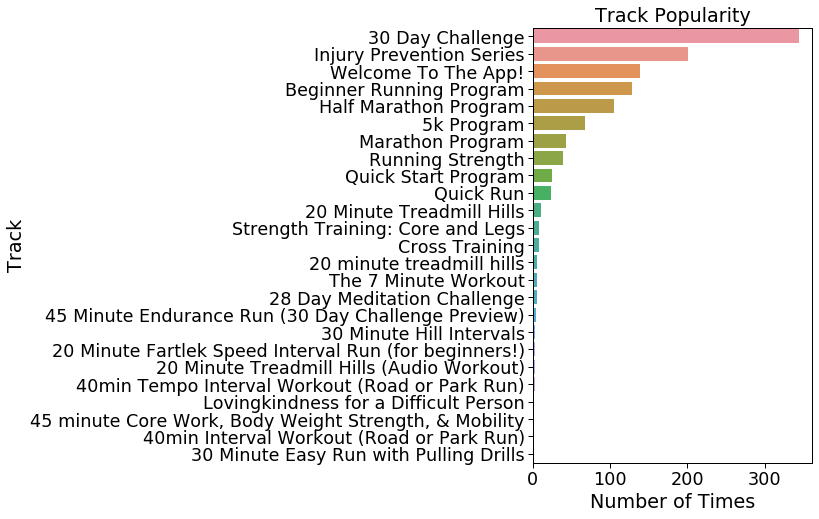

In [93]:
#Plot popularity of all workout tracks
all_tracks = TrackSession_df.groupby('trackTitle').count()
all_tracks = all_tracks.reset_index('trackTitle')
all_tracks = all_tracks.sort_values(by='_id',ascending=False)

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='_id',y='trackTitle', data=all_tracks)
plt.xlabel('Number of Times')
plt.ylabel('Track');
plt.title('Track Popularity');



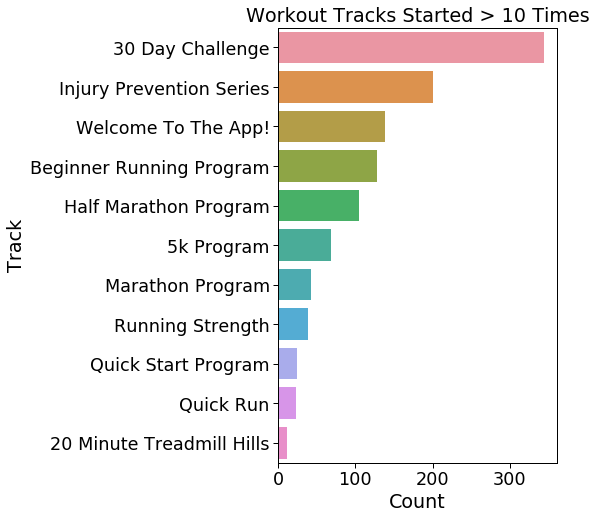

In [94]:
#Plot popularity of all workout tracks
popular_tracks = TrackSession_df.groupby('trackTitle').count()
popular_tracks = popular_tracks.reset_index('trackTitle')
popular_tracks = popular_tracks[popular_tracks['_id']>=10]
popular_tracks = popular_tracks.sort_values(by='_id',ascending=False)

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='_id',y='trackTitle', data=popular_tracks)
plt.xlabel('Count')
plt.ylabel('Track');
plt.title('Workout Tracks Started > 10 Times');

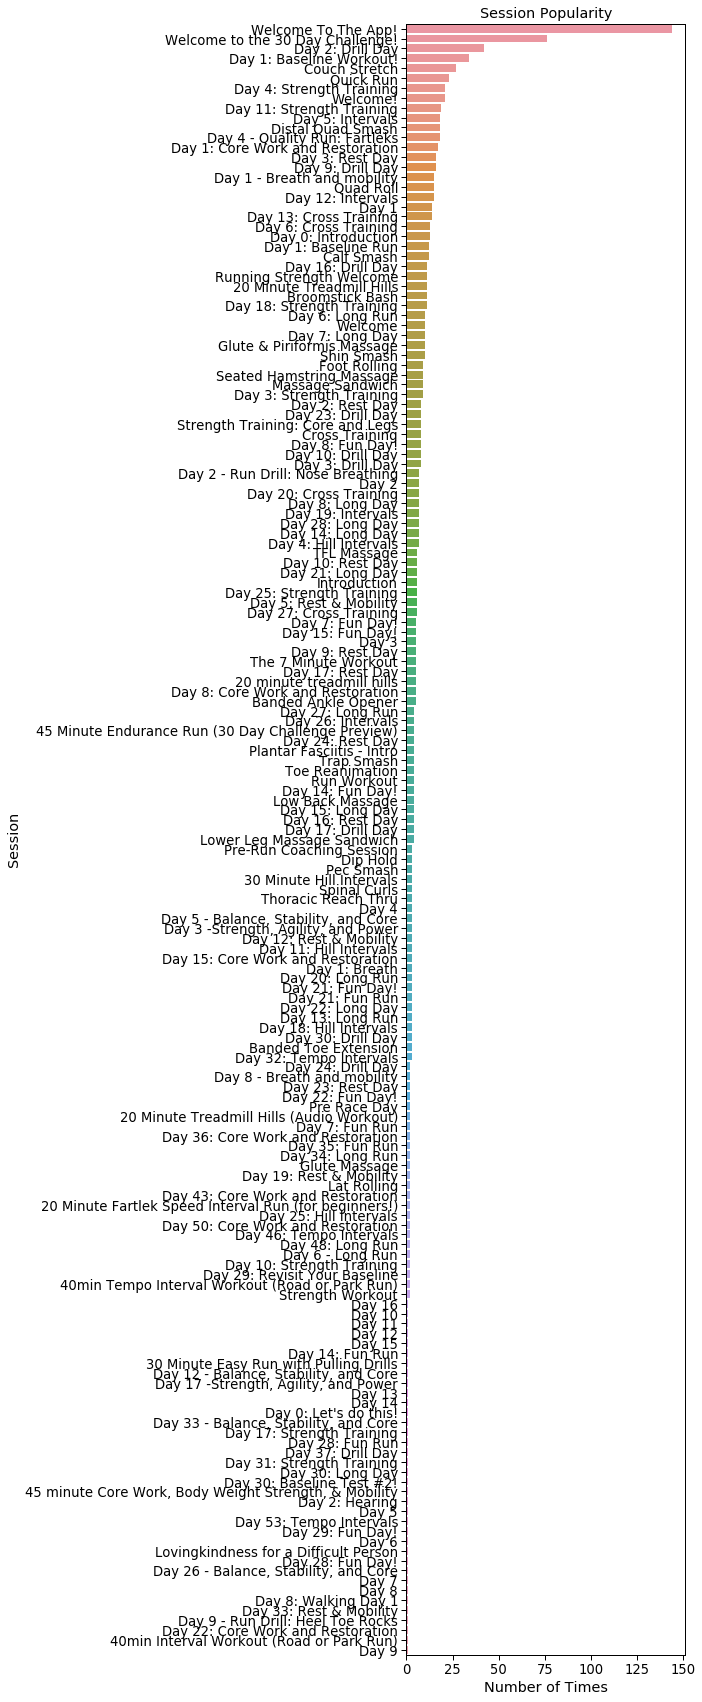

In [95]:
#Plot popularity of all workout sessions
all_sessions = TrackSession_df.groupby('sessionTitle').count()
all_sessions = all_sessions.reset_index('sessionTitle')
all_sessions = all_sessions.sort_values(by='_id',ascending=False)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(5, 30))
ax = sns.barplot(x='_id',y='sessionTitle', data=all_sessions)
plt.xlabel('Number of Times')
plt.ylabel('Session');
plt.title('Session Popularity');

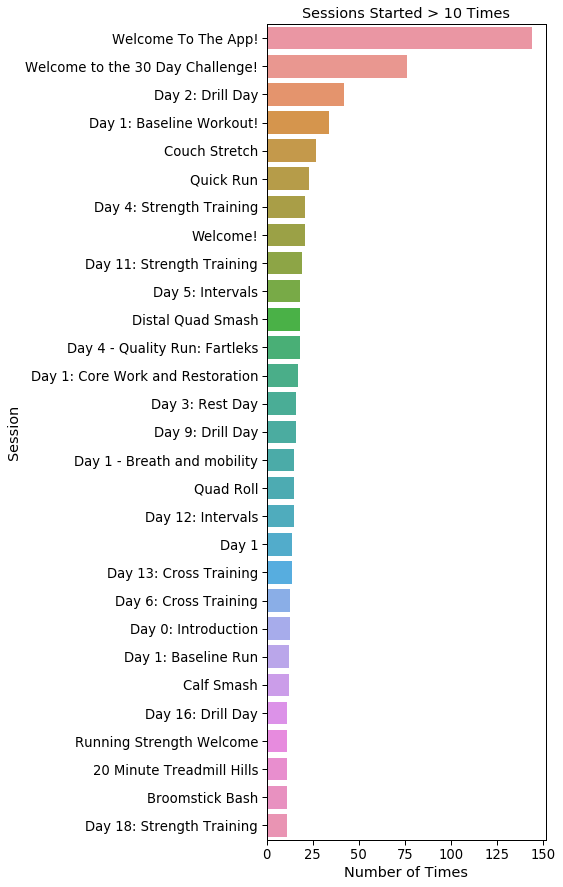

In [96]:
#Plot popularity of all workout sessions
popular_sessions = TrackSession_df.groupby('sessionTitle').count()
popular_sessions = popular_sessions.reset_index('sessionTitle')
popular_sessions = popular_sessions.sort_values(by='_id',ascending=False)
popular_sessions = popular_sessions[popular_sessions['_id']>10]

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(5, 15))
ax = sns.barplot(x='_id',y='sessionTitle', data=popular_sessions)
plt.xlabel('Number of Times')
plt.ylabel('Session');
plt.title('Sessions Started > 10 Times');

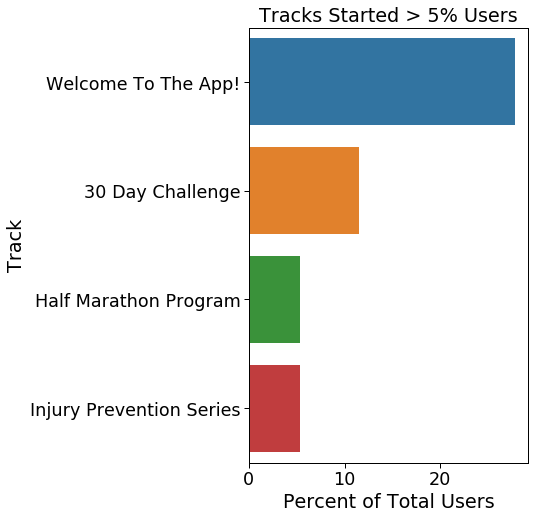

In [97]:
# Count the number of unique users doing each track and session
number_total_unique_users = UserLog_df['user'].nunique()
popular_tracks = TrackSession_df.groupby('trackTitle')['user'].nunique()
popular_tracks = popular_tracks.reset_index('trackTitle')
popular_tracks['UserFraction'] = [x/number_total_unique_users*100 for x in popular_tracks['user']]
#popular_tracks.head()
popular_tracks = popular_tracks[popular_tracks['UserFraction']>=5]
popular_tracks = popular_tracks.sort_values(by='UserFraction',ascending=False)

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='UserFraction',y='trackTitle', data=popular_tracks)
plt.xlabel('Percent of Total Users')
plt.ylabel('Track');
plt.title('Tracks Started > 5% Users');
plt.savefig('Tracks_started_by_more_than_5percent_users.png',bbox_inches='tight')


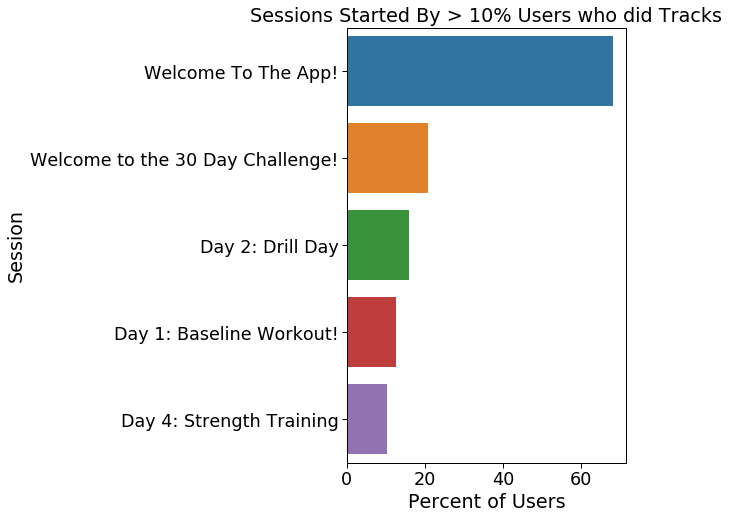

In [98]:
number_unique_track_users = TrackSession_df['user'].nunique()

popular_sessions = TrackSession_df.groupby('sessionTitle')['user'].nunique()
popular_sessions = popular_sessions.reset_index('sessionTitle')
popular_sessions['UserFraction'] = [x/number_unique_track_users*100 for x in popular_sessions['user']]

popular_sessions = popular_sessions[popular_sessions['UserFraction']>=10]
popular_sessions = popular_sessions.sort_values(by='UserFraction',ascending=False)

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='UserFraction',y='sessionTitle', data=popular_sessions)
plt.xlabel('Percent of Users')
plt.ylabel('Session');
plt.title('Sessions Started By > 10% Users who did Tracks');
plt.savefig('Sessions_started_by_more_than_10percent_track_users.png',bbox_inches='tight')


## Track Reviews of Activities

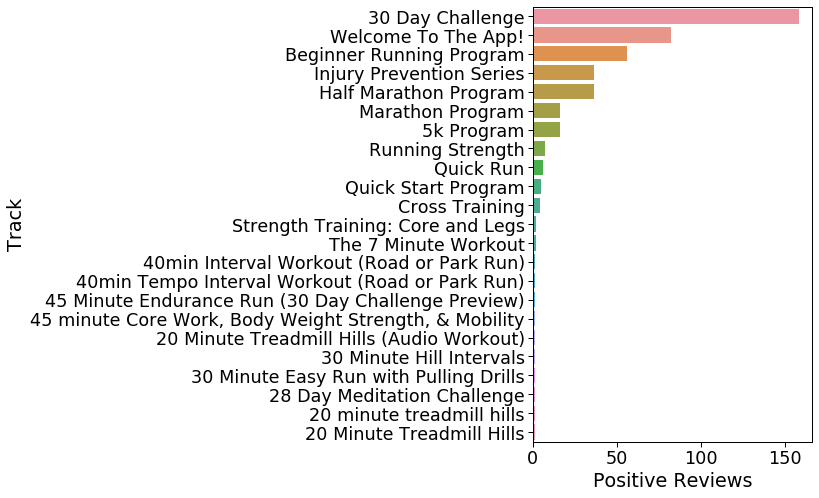

In [99]:
#Count the number of positive reviews for each workout track
track_thumbs_df = TrackFeedback_df.groupby('trackTitle').sum()
track_thumbs_df=track_thumbs_df.reset_index('trackTitle')
track_thumbs_df=track_thumbs_df.sort_values(by='Gave_Thumbs_Up', ascending=False)

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='Gave_Thumbs_Up',y='trackTitle', data=track_thumbs_df)
plt.xlabel('Positive Reviews')
plt.ylabel('Track');
plt.savefig('track_thumb_up_histogram.png',bbox_inches = 'tight')


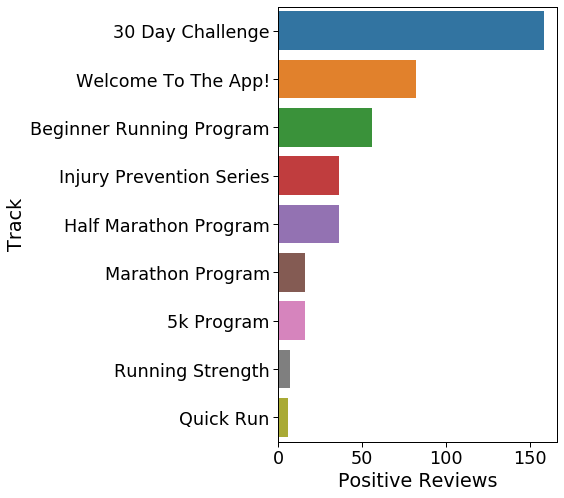

In [100]:
#Show only the tracks that received more than 5 positive reviews
track_thumbs_df = TrackFeedback_df.groupby('trackTitle').sum()
track_thumbs_df=track_thumbs_df.reset_index('trackTitle')
track_thumbs_df=track_thumbs_df.sort_values(by='Gave_Thumbs_Up', ascending=False)

thumbs_up_df = track_thumbs_df[track_thumbs_df['Gave_Thumbs_Up']>5]

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='Gave_Thumbs_Up',y='trackTitle', data=thumbs_up_df)
plt.xlabel('Positive Reviews')
plt.ylabel('Track');
plt.savefig('track_thumb_up_histogram.png',bbox_inches = 'tight')

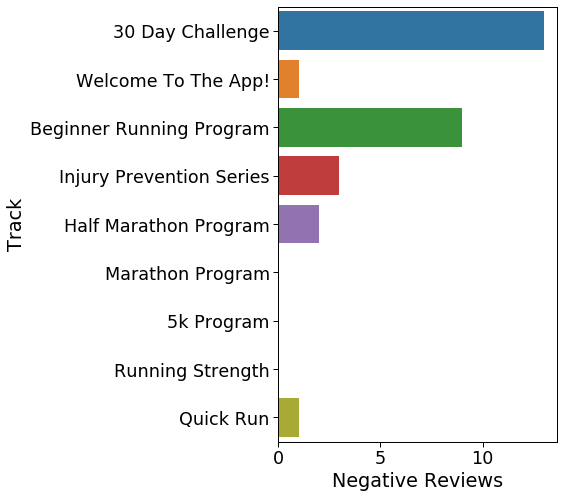

In [101]:
#Of tracks that received more than 5 positive reviews, plot the number of negative reviews
thumbs_down_df=track_thumbs_df[track_thumbs_df['Gave_Thumbs_Up']>5] #use thumbs up df so that colors are the same
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='Gave_Thumbs_Down',y='trackTitle', data=thumbs_down_df)
plt.xlabel('Negative Reviews')
plt.ylabel('Track');
plt.savefig('track_thumb_down_histogram.png', bbox_inches = 'tight')

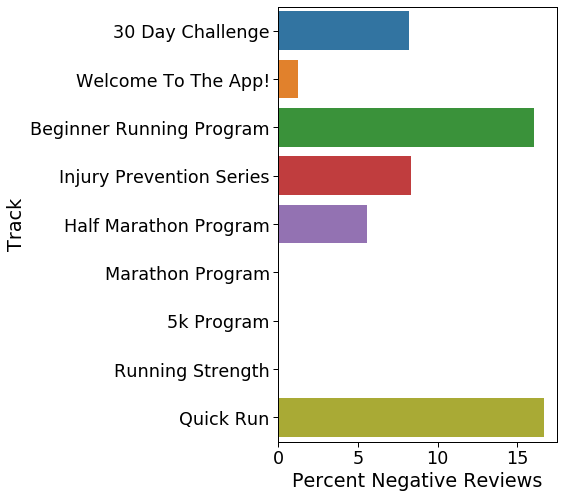

In [102]:
#Plot percentage of total reviews that are negative
thumbs_down_df['percent_negative'] = thumbs_down_df['Gave_Thumbs_Down']/thumbs_down_df['Gave_Thumbs_Up']*100


sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5, 8))
ax = sns.barplot(x='percent_negative',y='trackTitle', data=thumbs_down_df)
plt.xlabel('Percent Negative Reviews')
plt.ylabel('Track');
plt.savefig('percent_thumb_down_histogram.png', bbox_inches = 'tight')

### Plot least popular tracks in sessions

In [103]:
TrackFeedback_df.sort_values(by='Gave_Thumbs_Down', ascending=False) 

,_id,user,track,trackSession,thumbsUp,thumbsDownTimeReason,thumbsDownDifficultyReason,feedbackText,trackTitle,sessionTitle,...,category,createdAt,updatedAt,resolvedBy,tags,resolvedAt,DateTime_of_First_Login,Days_From_FirstLogin,Gave_Thumbs_Up,Gave_Thumbs_Down
208,685a181a-a22f-4933-a2aa-a8a374f00ec1,0234d304-2138-4384-9e86-6e2c86129b0a,00000000-57b4-d9d6-5353-be0e02a3665a,00000000-5864-6116-98dd-ba187685b01a,f,too-short,too-easy,The timer for the first calf roll is for only ...,Beginner Running Program,Day 9: Rest Day,...,NaN,2019-05-15 13:54:55.985+00,2019-05-15 13:54:55.985000+00:00,NaN,NaN,NaN,2019-04-01 02:37:25.060,44,0,1
174,6b6fdc68-ad7f-44b5-880a-9aa4c02c914a,1d09aa12-0ace-4fdb-ac53-098fe2bbe284,544e3df1-02f9-4086-8f53-7922257684c5,b57a7dca-a195-4476-b099-27d8ca645a15,f,NaN,too-easy,The video for the squat / burpee section was m...,30 Day Challenge,Day 4: Strength Training,...,Exercise,2019-05-22 20:53:29.202+00,2019-05-22 20:53:29.202000+00:00,NaN,NaN,NaN,2019-04-06 06:59:15.536,46,0,1
239,5548a291-3a12-4d65-bbc9-c569cad8c2aa,0234d304-2138-4384-9e86-6e2c86129b0a,00000000-57b4-d9d6-5353-be0e02a3665a,00000000-581c-b2aa-9004-ee14073e1b57,f,too-short,NaN,Allow for time between exercises to get in pos...,Beginner Running Program,Day 4: Strength Training,...,NaN,2019-05-10 14:33:42.064+00,2019-05-10 14:33:42.064000+00:00,NaN,NaN,NaN,2019-04-01 02:37:25.060,39,0,1
327,c728dfc3-7cc4-4841-8552-557c7ba83f6f,24691a9f-60bc-4c82-86b0-3099002cc307,00000000-57b4-d9d6-5353-be0e02a3665a,00000000-586d-d8f0-98dd-ba187685b315,f,NaN,NaN,Are these time allotments right? I felt like I...,Beginner Running Program,Day 18: Strength Training,...,NaN,2019-04-30 22:33:59.973+00,2019-04-30 22:33:59.973000+00:00,NaN,NaN,NaN,2019-03-28 23:16:19.182,32,0,1
478,f25ad3a0-f11f-4b1d-8c73-83b11c42359d,b7ebb563-de17-452d-8521-ce41a01a5982,544e3df1-02f9-4086-8f53-7922257684c5,528814f4-df86-408f-bfbd-5b8681a136c1,f,NaN,NaN,It would be nice to be able to pick up where y...,30 Day Challenge,Day 1: Baseline Workout!,...,Exercise,2019-03-25 18:05:00.725+00,2019-03-25 18:05:00.725000+00:00,NaN,NaN,NaN,2019-03-23 19:04:32.689,1,0,1
75,66d0297e-034b-4017-9d3f-73cfdee1cd54,2035eee1-901c-4aa6-a877-1342ecb19f65,a1587f13-56e7-494f-9b26-65387e996220,fc45c099-4ae9-4624-a063-7f4e7f23d8d1,f,too-short,NaN,The prescription said for 2-3 minutes per side...,Injury Prevention Series,TFL Massage,...,Exercise,2019-06-05 01:00:34.117+00,2019-06-05 01:00:34.117000+00:00,NaN,NaN,NaN,2019-03-26 17:28:02.397,70,0,1
353,b7ae17d4-d8d5-4fe0-b048-d3a7e82b9176,652d0003-2021-4cbb-a308-ba81e78af1d2,0be3289e-1dd4-45df-876f-f876d1ea9b72,238c25eb-17c8-480c-97c3-e61fb804b5fd,f,NaN,NaN,Content was good. I was watching on my iPad an...,Welcome To The App!,Welcome To The App!,...,Exercise,2019-04-28 22:54:42.656+00,2019-04-28 22:54:42.656000+00:00,NaN,NaN,NaN,2019-04-28 22:38:30.114,0,0,1
196,362a39a5-c378-4f1c-bb29-d200bc295403,0234d304-2138-4384-9e86-6e2c86129b0a,00000000-57b4-d9d6-5353-be0e02a3665a,00000000-5864-6116-98dd-ba187685b01c,f,NaN,NaN,Has a beginner tested this segment? Doing a sq...,Beginner Running Program,Day 11: Strength Training,...,NaN,2019-05-17 14:21:08.555+00,2019-05-17 14:21:08.555000+00:00,NaN,NaN,NaN,2019-04-01 02:37:25.060,46,0,1
83,8d323c50-520b-4ab6-87a0-6332ad7e3806,58b78117-2a67-4b16-badf-f4b50505ac4f,544e3df1-02f9-4086-8f53-7922257684c5,76a0d9ea-f048-46a8-9017-2b7f040268bb,f,NaN,NaN,The referenced mobility work is not a part of ...,30 Day Challenge,Day 24: Rest Day,...,Exercise,2019-06-04 10:41:17.922+00,2019-06-04 10:41:17.922000+00:00,NaN,NaN,NaN,2019-04-28 16:28:19.890,36,0,1
92,628bf938-62e7-48d3-9cc3-27074f1c0c2c,211fa042-6a6e-4f16-9f7b-885d4509f14c,544e3df1-02f9-4086-8f53-7922257684c5,19a497bb-8bc9-4e17-ba56-acf4153175fb,f,NaN,NaN,NaN,30 Day Challenge,Welcome to the 30 Day Challenge!,...,Exercise,2019-06-03 10:55:34.599+00,2019-06-03 10:55:34.599000+00:00,NaN,NaN,NaN,2019-03-10 02:25:29.929,85,0,1


In [104]:
most_negative_tracks = ['30 Day Challenge', 'Beginner Running Program', 'Quick Run']
problem_tracks_df = TrackFeedback_df[TrackFeedback_df.trackTitle.isin(most_negative_tracks)]

problem_sessions = pd.DataFrame(problem_tracks_df.groupby(['trackTitle','sessionTitle'])['Gave_Thumbs_Down'].sum())
problem_sessions.sort_values(by=['trackTitle','Gave_Thumbs_Down'], ascending=False)

Gave_Thumbs_Down
trackTitle               sessionTitle                                      
Quick Run                Quick Run                                        1
Beginner Running Program Day 4: Strength Training                         2
                         Day 11: Strength Training                        1
                         Day 13: Cross Training                           1
                         Day 16: Rest Day                                 1
                         Day 17: Drill Day                                1
                         Day 18: Strength Training                        1
                         Day 1: Baseline Run                              1
                         Day 9: Rest Day                                  1
                         Day 0: Introduction                              0
                         Day 10: Drill Day                                0
                         Day 12: Intervals                                0
                         Day 19: Intervals                                0
                         Day 20: Cross Training                           0
                         Day 21: Fun Day!                                 0
                         Day 22: Long Day                                 0
                         Day 23: Rest Day                                 0
                         Day 24: Drill Day                                0
                         Day 2: Rest Day                                  0
                         Day 3: Drill Day                                 0
                         Day 5: Intervals                                 0
                         Day 6: Cross Training                            0
                         Day 7: Fun Day!                                  0
                         Day 8: Long Day                                  0
30 Day Challenge         Day 1: Baseline Workout!                         2
                         Day 5: Intervals                                 2
                         Day 11: Strength Training                        1
                         Day 18: Strength Training                        1
                         Day 19: Intervals                                1
                         Day 24: Rest Day                                 1
                         Day 4: Strength Training                         1
                         Day 6: Cross Training                            1
                         Day 7: Long Day                                  1
                         Day 9: Drill Day                                 1
                         Welcome to the 30 Day Challenge!                 1
                         Day 10: Rest Day                                 0
                         Day 12: Intervals                                0
                         Day 13: Cross Training                           0
                         Day 14: Long Day                                 0
                         Day 15: Fun Day!                                 0
                         Day 16: Drill Day                                0
                         Day 17: Rest Day                                 0
                         Day 20: Cross Training                           0
                         Day 21: Long Day                                 0
                         Day 22: Fun Day!                                 0
                         Day 23: Drill Day                                0
                         Day 25: Strength Training                        0
                         Day 26: Intervals                                0
                         Day 28: Long Day                                 0
                         Day 2: Drill Day                                 0
                         Day 30: Baseline Test #2!                        0
                         Day 3:

In [105]:
#merge negative comments with the corresponding programs
session_neg_comment_df = problem_tracks_df.set_index(['trackTitle','sessionTitle'])
session_neg_comment_df = session_neg_comment_df[session_neg_comment_df['Gave_Thumbs_Down']==1]

session_neg_comment_df = session_neg_comment_df.sort_values(by=['trackTitle','Gave_Thumbs_Down'], ascending=False)

In [106]:
#Print the negative reviews for manual parsing
for feedback in session_neg_comment_df.feedbackText:
    print(feedback)
    print('')



nan

Content and design are good. Functionality of app is horrible. My connection is 42.4, yet the video would not advance between drills.

Love the rolling instruction. Thumbs down because there was no timer set to accomplish them. With the exception of one timer set for one lateral child’s pose. Even that one didn’t alert when the minute was up. 

Every day the app tells me my network connection is slow. When I test my connection it is at 172 Mbps

Also today’s program hung up at the final plank, causing me to have to restart. 

Has a beginner tested this segment? Doing a squat then a sit up in 6 seconds seems unrealistic. There’s no time worked on for getting into position.  

The timer for the first calf roll is for only one side. Please repeat timer for second side. 

Allow for time between exercises to get in position. For example getting up to a standing position from a sit up so that action does not eat into the time for the other exercise in the couplet. 

Are these time allot

Manually tabulated reasons for negative feedback  
30 total thumb downs. 22 of which are in "Beginner Run Routine" and "30 Day Challenge"  
missing mobility work = 1  
nan = 1+1  
app connectivity = 1 + 1+1  
missing / malfunctioning app timer = 1+1  
missing burpee reps section or skip section = 1+1+1+1  
app froze/crash = 1+1+1+1+1+1  
difficulty (too fast between sets)= 1+1+1  
workout longer than expected from description = 1  
  
Totals:  
nan = 2  
missing expected sections of workout = 5  
App/GPS connectivity = 3  
Malfunctioning in-app timer = 2  
Frozen app = 6  
Not Enough Time between sets = 3  
Workout too long = 1  

Broad categories:  
App frozen/GPS/bad timer = (3+2+6) = 11/22  
Difficulty = 4/22  

# Data Exploration and Engineering of Master Daily Df


## Evaluate Churn of Users with > 30 Days App Usage

In [107]:
long_users = Master_Day_df.reset_index(['user','Days_From_FirstLogin'])




In [108]:
#Identify users that have had the app for more than 30 days. This does not necessarily mean that
#the user has been active the entire time. Just that their first login was over 30 days ago
max_app_ownership = long_users.groupby('user')['Days_Ago_Logged_In'].max()
keys_to_keep = max_app_ownership[max_app_ownership.values>30].keys()


In [109]:
longtime_user_df = long_users[long_users.user.isin(keys_to_keep)]
long_user_max_app_ownership = longtime_user_df.groupby('user')['Days_From_FirstLogin'].max()

#calculate the sum of activities down by each user over the course of app ownership
longtime_user_df = longtime_user_df.groupby('user').sum()

#reset the summed "Days_From_FirstLogin" column to the actual max length of app ownership
longtime_user_df['Days_From_FirstLogin'] = long_user_max_app_ownership.values
longtime_user_df = longtime_user_df.rename(columns = {'Days_From_FirstLogin':'Length_of_App_Usage_days'})

#Define new "churned" column. 1 if the user has logged in within the last 30 days. 0 otherwise
#Then drop the useless 'LoggedInLast30Days_Y_N' column
longtime_user_df['Churned'] = [1 if x==0 else 0 for x in longtime_user_df['LoggedInLast30Days_Y_N']]
longtime_user_df = longtime_user_df.drop(columns = ['LoggedInLast30Days_Y_N'])

#Drop Login column because this doesn't do a good job of segmenting users
longtime_user_df = longtime_user_df.drop(columns = 'Logins')

#Drop Days_Ago_Logged_In column because when the user first logged in shouldn't be relevant
longtime_user_df = longtime_user_df.drop(columns = 'Days_Ago_Logged_In')

longtime_user_df.head()

,Length_of_App_Usage_days,num_activities,num_sessions,num_run_workouts,Gave_Thumbs_Up,Gave_Thumbs_Down,num_newsfeed_posts,num_newsfeed_comments,num_newsfeed_likes,num_questions_asked,num_questions_upvoted,num_answers_posted,num_answers_upvoted,Churned
user,,,,,,,,,,,,,,
00000000-5704-6615-a2ab-44376358dc8e,132,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00000000-5777-0b85-44c3-2a2c22b8b0e7,85,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,0.0,0.0,0.0,0.0,1
00000000-579f-f5c5-aa50-e8f732c1ba9a,111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00000000-584d-a4f0-bdee-d4102b989ce5,128,5.0,6.0,4.0,1.0,0.0,15.0,14.0,140.0,0.0,15.0,1.0,0.0,0
00000000-584e-1f39-bdee-d4102b989d01,127,3.0,7.0,7.0,1.0,0.0,9.0,1.0,30.0,1.0,0.0,0.0,0.0,0


### Cox Proportional Hazard Model for Users Engaged in Social Media

In [114]:
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter, CoxPHFitter

#Find the users that asked questions, answered questions, posted to newsfeed, or liked anything
idx_users_engaged = longtime_user_df.iloc[:, -8:-1].any(axis=1).values

engaged_users = longtime_user_df[idx_users_engaged]
engaged_users['Length_of_App_Usage_days'] = engaged_users['Length_of_App_Usage_days']+1 #Need to add 1 to time so that the start day is not 0. Throws error if start at 0

#Evaluate different models for fitting the 
llf = LogLogisticAFTFitter().fit(engaged_users, 'Length_of_App_Usage_days', 'Churned')
lnf = LogNormalAFTFitter().fit(engaged_users, 'Length_of_App_Usage_days', 'Churned')
wf = WeibullAFTFitter().fit(engaged_users, 'Length_of_App_Usage_days', 'Churned')
cph = CoxPHFitter().fit(engaged_users, 'Length_of_App_Usage_days', 'Churned')

print(llf._log_likelihood)  # -194.9
print(lnf._log_likelihood)  # -195.8 slightly the best, but not much different
print(wf._log_likelihood)   # -194.86
print(cph._log_likelihood)  # -131.98 lowest, but the parameters for each variable make the most sense (i.e. thumbs down is associated with more churn)

-194.65945958082412
-196.03754519970641
-194.21085523803416
-131.975538696892


In [115]:
cph = CoxPHFitter()
cph.fit(engaged_users, duration_col='Length_of_App_Usage_days', event_col='Churned', show_progress=True)
cph.print_summary()  # access the results using cph.summary


Iteration 8: norm_delta = 0.00018, step_size = 1.0000, ll = -131.97554, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 8 iterations.
<lifelines.CoxPHFitter: fitted with 113 observations, 80 censored>
      duration col = 'Length_of_App_Usage_days'
         event col = 'Churned'
number of subjects = 113
  number of events = 33
partial log-likelihood = -131.98
  time fit was run = 2019-07-01 20:51:16 UTC

---
                       coef exp(coef)  se(coef)     z    p  -log2(p)  lower 0.95  upper 0.95
num_activities        -0.01      0.99      0.01 -0.55 0.58      0.78       -0.04        0.02
num_sessions          -0.07      0.93      0.13 -0.55 0.58      0.78       -0.33        0.19
num_run_workouts      -0.01      0.99      0.09 -0.10 0.92      0.12       -0.19        0.17
Gave_Thumbs_Up        -0.07      0.93      0.25 -0.27 0.79      0.35       -0.56        0.42
Gave_Thumbs_Down       0.37      1.45      0.97  0.38 0.70      0.51       -1.52        2.

In [116]:
#Check to see if cox proportional hazard assumptions are 
cph.check_assumptions(engaged_users, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


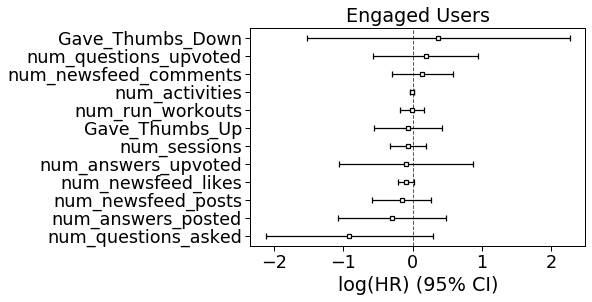

In [117]:
cph.plot()
plt.title('Engaged Users');
plt.savefig('Engaged_User_CPH_params.png',bbox_inches = 'tight')

In [118]:
#Calculate the concordance score of the CPH model using cross fold validation. The concordance score is a measure
#of how well the model does at predicting the *order* at which users will leave. A good score is between 0.55 and 0.75 (best is 1)

from lifelines.utils import k_fold_cross_validation
scores = k_fold_cross_validation(cph, engaged_users, 'Length_of_App_Usage_days', event_col='Churned', k=5)
kfold_5_engaged_scores = scores
kfold_5_engaged_err = np.std(scores)


print('Concordance Scores for Engaged Users')
print(scores)
print(np.mean(scores))
print(np.std(scores))



Concordance Scores for Engaged Users
[0.4666666666666667, 0.6041666666666666, 0.5317460317460317, 0.8041237113402062, 0.47368421052631576]
0.5760774573891775
0.12426944197841192


### Cox Proportional Hazard Model for Unengaged Users

In [119]:
unengaged_users = longtime_user_df[~idx_users_engaged]
unengaged_users = unengaged_users.drop(unengaged_users.iloc[:, -8:-1], axis=1)
unengaged_users['Length_of_App_Usage_days'] = unengaged_users['Length_of_App_Usage_days'] +1
cph.fit(unengaged_users, duration_col='Length_of_App_Usage_days', event_col='Churned', show_progress=True)
cph.print_summary()  # access the results using cph.summary

Iteration 8: norm_delta = 0.00015, step_size = 1.0000, ll = -604.68366, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 8 iterations.
<lifelines.CoxPHFitter: fitted with 243 observations, 120 censored>
      duration col = 'Length_of_App_Usage_days'
         event col = 'Churned'
number of subjects = 243
  number of events = 123
partial log-likelihood = -604.68
  time fit was run = 2019-07-01 20:51:26 UTC

---
                  coef exp(coef)  se(coef)     z    p  -log2(p)  lower 0.95  upper 0.95
num_activities    0.00      1.00      0.01  0.11 0.91      0.13       -0.02        0.02
num_sessions     -0.25      0.77      0.11 -2.37 0.02      5.82       -0.47       -0.04
num_run_workouts -0.05      0.95      0.12 -0.44 0.66      0.60       -0.28        0.18
Gave_Thumbs_Up   -0.01      0.99      0.22 -0.03 0.97      0.04       -0.44        0.43
Gave_Thumbs_Down  0.88      2.41      0.32  2.79 0.01      7.55        0.26        1.50
---
Concordance = 0.61
Lo

In [120]:
cph.check_assumptions(unengaged_users, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


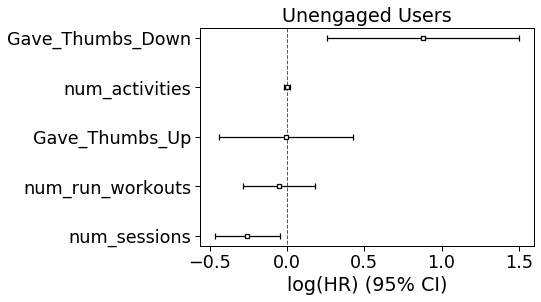

In [121]:
cph.plot()
plt.title('Unengaged Users')
plt.savefig('Unengaged_user_CPH_plot.png',bbox_inches = 'tight')

In [122]:
#K fold cross validation for unengaged users
scores = k_fold_cross_validation(cph, unengaged_users, 'Length_of_App_Usage_days', event_col='Churned', k=5)
print('Concordance Scores for Engaged Users')
print(scores)
print(np.mean(scores))
print(np.std(scores))

kfold_5_unengaged = scores
kfold_5_unengaged_err = np.std(scores)

Concordance Scores for Engaged Users
[0.5514322916666666, 0.6684141546526867, 0.5953545232273839, 0.6161745827984596, 0.5683269476372924]
0.5999404999964979
0.040806080374035804


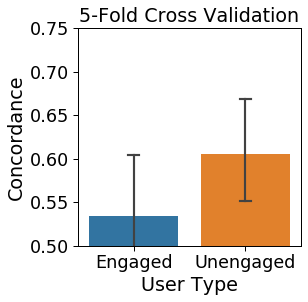

In [123]:
#Create a historgram of the concordance scores for the engaged and unengaged users CPH models
CPH_fit_dict = {'5_Fold_Concordance_Mean': [kfold_5_engaged_scores[0],kfold_5_engaged_scores[1], kfold_5_engaged_scores[2], kfold_5_unengaged[0],kfold_5_unengaged[1],kfold_5_unengaged[2]],
               'Categories':['Engaged', 'Engaged','Engaged','Unengaged','Unengaged','Unengaged']}

CPH_fit_df = pd.DataFrame(data=CPH_fit_dict)
CPH_fit_df
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(4, 4))
ax = sns.barplot(x='Categories',y='5_Fold_Concordance_Mean', data=CPH_fit_df, capsize=.1)
plt.xlabel('User Type')
plt.ylabel('Concordance');
plt.ylim(0.5,0.75)
plt.title('5-Fold Cross Validation');
plt.savefig('5-fold_CPH_cross_validation.png', bbox_inches = 'tight')

### Plot Effect of "Thumbs-Down" on Retention of Unengaged and Engaged Users
"Thumbs down" was the most significant predictor of user churn in the CPH models. This may not be the case in future iterations of the model, but the general code may still be applied

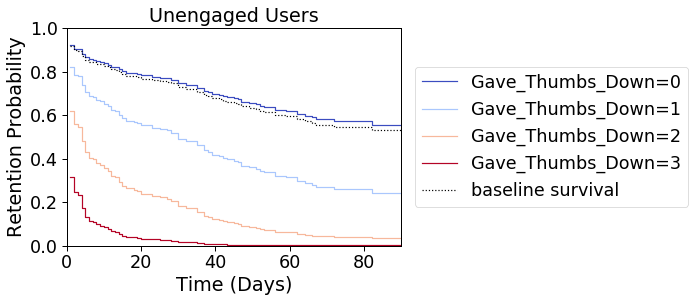

In [124]:
#CPH of unengaged users and engaged users varying the number of dislikes
cph.fit(unengaged_users, duration_col='Length_of_App_Usage_days', event_col='Churned')

cph.plot_covariate_groups('Gave_Thumbs_Down', [0,1,2,3], cmap='coolwarm');
plt.xlim(0,90)
plt.title('Unengaged Users')
plt.ylabel('Retention Probability')
plt.xlabel('Time (Days)')
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.savefig('unengaged_thumbs_down_cph_variation.png',bbox_inches='tight')

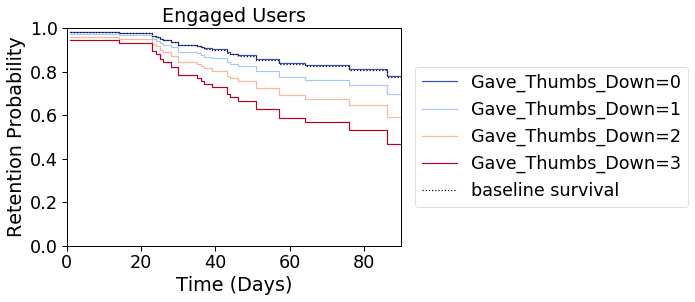

In [133]:
cph.fit(engaged_users, duration_col='Length_of_App_Usage_days', event_col='Churned')
cph.plot_covariate_groups('Gave_Thumbs_Down', [0,1,2,3], cmap='coolwarm');
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title('Engaged Users')
plt.ylabel('Retention Probability')
plt.xlabel('Time (Days)')
plt.xlim(0,90)
plt.ylim(0,1)
plt.savefig('engaged_thumbs_down_cph_variation.png',bbox_inches='tight')


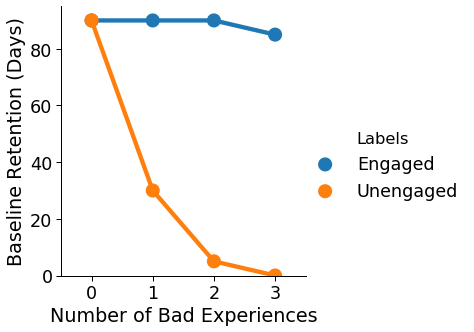

In [134]:
#Pull out median survivals by eye based upon the CPH covariate curves for the effect of thumbs down 
#on retention of engaged and unengaged users
median_survivals_engaged = [90,90,90,85]
median_survivals_unengaged = [90, 30, 5, 0]
survival_labels = ['Engaged']*4 + ['Unengaged']*4
negative_experiences = [0,1,2,3,0,1,2,3]
survival_times = median_survivals_engaged + median_survivals_unengaged

survival_dict = {'Survival_Times':survival_times,'Neg_Exp':negative_experiences,'Labels':survival_labels}
survival_df = pd.DataFrame(data=survival_dict)
survival_df.head()

sns.catplot(x="Neg_Exp", y="Survival_Times", hue="Labels", kind="point", scale = 2, data=survival_df);
plt.ylim(0,95)
plt.xlabel('Number of Bad Experiences')
plt.ylabel('Baseline Retention (Days)');
plt.savefig('Change_in_retention_time.png',bbox_inches='tight')

## Kaplan-Meier for engaged vs unengaged users
Create a population level prediction of user retention vs time

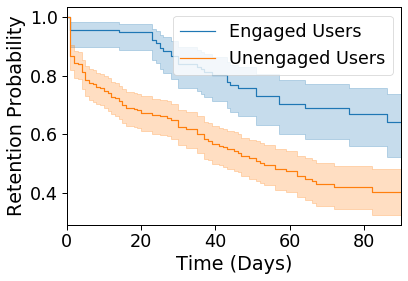

In [126]:
#Plot the retention probability vs time of users that have owned the app for more than 30 days
#Split these users into those that have used the newsfeed, questions, comments sections (engaged) 
#vs those that have not used those app features
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
#longtime_user_df['Length_of_App_Usage_days'], event_observed=longtime_user_df['Churned']

kmf.fit(engaged_users['Length_of_App_Usage_days'], event_observed=engaged_users['Churned'], label="Engaged Users")
kmf.plot(ax=ax);
kmf.fit(unengaged_users['Length_of_App_Usage_days'], event_observed=unengaged_users['Churned'], label="Unengaged Users")
kmf.plot(ax=ax)
plt.xlim(0,90)
plt.xlabel('Time (Days)')
plt.ylabel('Retention Probability');
plt.savefig('kmf_engaged_vs_unengaged_users.png',bbox_inches = 'tight')

## Make retention predictions for censored subjects

In [127]:
all_user_logins_df = Master_Day_df.groupby('user').tail(1)
all_user_logins_df =all_user_logins_df.reset_index('Days_From_FirstLogin').rename(columns = {'Days_From_FirstLogin':'Length_of_App_Usage_days'})

#Make new "Churned" column for if the user hasn't logged into the app in the last 30 day
all_user_logins_df['Churned'] = [0 if x==1 else 1 for x in all_user_logins_df['LoggedInLast30Days_Y_N']]

#Add 1 to the Length_of_App_Usage_days so that day 0 is now day 1 (do this for personal preference,
# and it helps with other model fits that can't accept 0 time)
all_user_logins_df['Length_of_App_Usage_days'] = [x+1 for x in all_user_logins_df['Length_of_App_Usage_days']]

drop_columns = all_user_logins_df.iloc[:, 4:-1].columns
all_user_logins_df =all_user_logins_df.drop(columns = drop_columns)
all_user_logins_df = all_user_logins_df.drop(columns = ['Logins','Days_Ago_Logged_In','LoggedInLast30Days_Y_N'])
all_user_logins_df.head()
len(all_user_logins_df)

486

In [128]:
from lifelines.utils import median_survival_times, qth_survival_times

df = unengaged_users
cph = CoxPHFitter().fit(df, 'Length_of_App_Usage_days', 'Churned')
censored_subjects = df.loc[df['Churned'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)

conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df.loc[c.name, 'Length_of_App_Usage_days']]).clip(upper=1))
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 243 observations, 120 censored>
      duration col = 'Length_of_App_Usage_days'
         event col = 'Churned'
number of subjects = 243
  number of events = 123
partial log-likelihood = -604.68
  time fit was run = 2019-07-01 20:52:01 UTC

---
                  coef exp(coef)  se(coef)     z    p  -log2(p)  lower 0.95  upper 0.95
num_activities    0.00      1.00      0.01  0.11 0.91      0.13       -0.02        0.02
num_sessions     -0.25      0.77      0.11 -2.37 0.02      5.82       -0.47       -0.04
num_run_workouts -0.05      0.95      0.12 -0.44 0.66      0.60       -0.28        0.18
Gave_Thumbs_Up   -0.01      0.99      0.22 -0.03 0.97      0.04       -0.44        0.43
Gave_Thumbs_Down  0.88      2.41      0.32  2.79 0.01      7.55        0.26        1.50
---
Concordance = 0.61
Log-likelihood ratio test = 30.62 on 5 df, -log2(p)=16.46


In [130]:
#add columns for times of different percent chances of leaving
predictions_50 = median_survival_times(conditioned_sf)
predictions_60 = qth_survival_times(0.6, conditioned_sf)
values = predictions_60.transpose().join(unengaged_users['Length_of_App_Usage_days'])
values['RemainingValue_Dollars']= 20/30 * (values[0.6] - values['Length_of_App_Usage_days'])
values = values.join(predictions_50.transpose())
values = values.sort_values(by='Length_of_App_Usage_days')


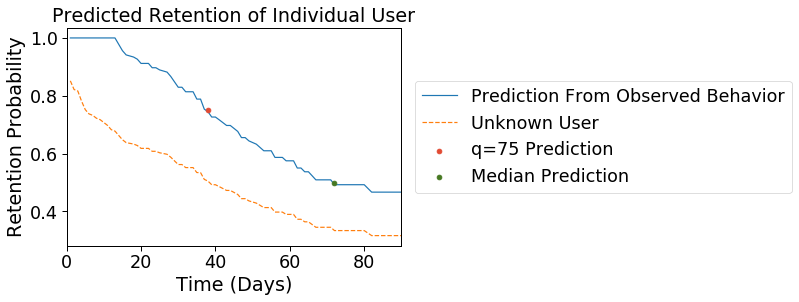

In [131]:
#For an arbitrary subject, plot the predicted survival time if nothing is known about the subject ("unconditioned")
#and if it is known that the subject has already remained active for a set amount of time ("conditioned")
subject = 'af799fed-fce8-48c9-bcd2-97ff96748739'

conditioned_sf[subject].plot( label="Prediction From Observed Behavior")
unconditioned_sf[subject].plot(ls="--",  label="Unknown User")

plt.scatter(qth_survival_times(0.75, conditioned_sf[subject]), 0.75,  color="#E24A33", label="q=75 Prediction", zorder=20)
plt.scatter(qth_survival_times(0.5, conditioned_sf[subject]), 0.5,  color="#467821", label="Median Prediction", zorder=20)
plt.xlim(0,90)
plt.ylabel('Retention Probability')
plt.xlabel('Time (Days)')
plt.title('Predicted Retention of Individual User')

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);
plt.savefig('retention_probability_of_individual_user.png', bbox_inches = 'tight')